# Introduction To convolutional layers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import Image

import sys
sys.path.insert(0, '/home/valeodar/caffe/python')

import caffe

caffe_root = '/home/valeodar/caffe_0/'
caffe_root_ex = '/home/valeodar/caffe_0/examples/'

# configure plotting
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

ImportError: No module named google.protobuf.internal

In [ ]:
# Load the net, list its data and params, and filter an example image.
caffe.set_mode_cpu()
net = caffe.Net(caffe_root_ex+'net_surgery/conv.prototxt', caffe.TEST)
print("blobs {}\nparams {}".format(net.blobs.keys(), net.params.keys()))

# load image and prepare as a single input batch for Caffe
image_file = caffe_root_ex + 'images/cat_gray.jpg'
im = np.array(Image.open(image_file))
plt.title("original image")
plt.imshow(im)
plt.axis('off')


im_input = im[np.newaxis, np.newaxis, :, :]
print(im_input.shape)
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input

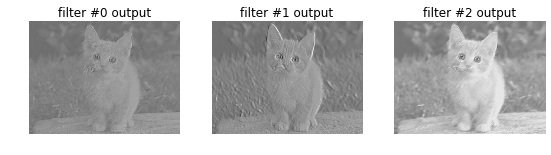

In [3]:
# helper show filter outputs
def show_filters(net):
    net.forward()
    plt.figure()
    filt_min, filt_max = net.blobs['conv'].data.min(), net.blobs['conv'].data.max()
    for i in range(3):
        plt.subplot(1,4,i+2)
        plt.title("filter #{} output".format(i))
        plt.imshow(net.blobs['conv'].data[0, i], vmin=filt_min, vmax=filt_max)
        plt.tight_layout()
        plt.axis('off')

# filter the image with initial 
show_filters(net)

In [4]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padvalue=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padvalue, padvalue))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    print data.shape
    if data.ndim > 2 :
        if data.shape[2] == 1:
            plt.imshow(data[:,:,0])
        else:
            plt.imshow(data)
    else:
        plt.imshow(data)

(3, 5, 5, 1)
(12, 12, 1)


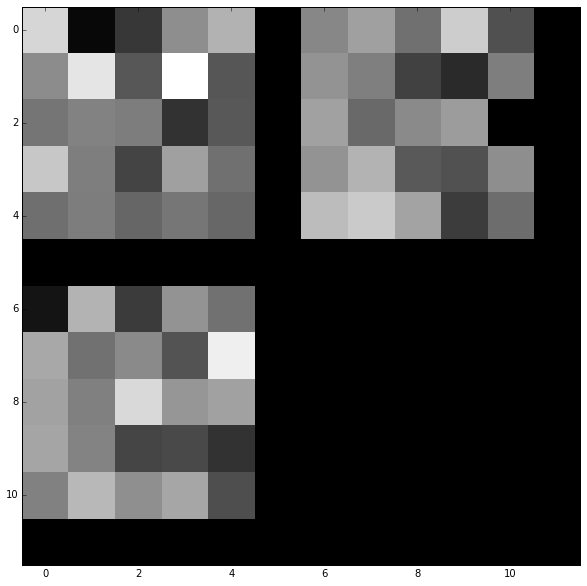

In [5]:
l1ftrs = net.params['conv'][0].data.transpose(0,2,3,1)
print l1ftrs.shape
vis_square(net.params['conv'][0].data.transpose(0,2,3,1))

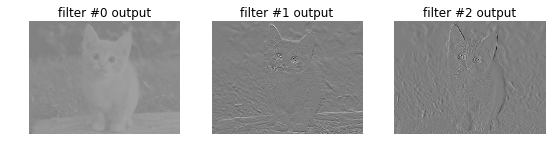

In [6]:
ksize = net.params['conv'][0].data.shape[2:]
# make Gaussian blur
sigma = 1.
y, x = np.mgrid[-ksize[0]//2 + 1:ksize[0]//2 + 1, -ksize[1]//2 + 1:ksize[1]//2 + 1]
g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
gaussian = (g / g.sum()).astype(np.float32)
net.params['conv'][0].data[0] = gaussian
# make Sobel operator for edge detection
net.params['conv'][0].data[1:] = 0.
sobel = np.array((-1, -2, -1, 0, 0, 0, 1, 2, 1), dtype=np.float32).reshape((3,3))
net.params['conv'][0].data[1, 0, 1:-1, 1:-1] = sobel  # horizontal
net.params['conv'][0].data[2, 0, 1:-1, 1:-1] = sobel.T  # vertical
show_filters(net)

Above surgery turns the 0th filter into a Gaussian blur and the 1st and 2nd filters into the horizontal and vertical gradient parts of the Sobel operator.

See how the 0th output is blurred, the 1st picks up horizontal edges, and the 2nd picks up vertical edges.

# Visualize a full trained net

## So far we have visualized a simple, single-layer, untrained network. We will see what a full trained network looks like

image shape =  (306, 460, 3)
100 loops, best of 3: 14.9 ms per loop
Predicted class is #386.
Class Predicted # 386 is : = n02504458 African elephant, Loxodonta africana


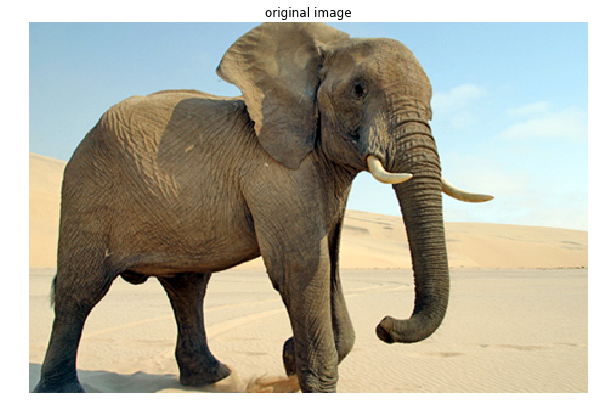

In [7]:
caffe_root = '/home/valeodar/caffe_0/'  # this file is expected to be in {caffe_root}
import os
if not os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print("Downloading pre-trained CaffeNet model...")
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

caffe.set_mode_gpu()
net2 = caffe.Net(caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt',
                caffe_root + 'models/bvlc_reference_caffenet/params.caffemodel',
                caffe.TEST)
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net2.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

net2.blobs['data'].reshape(1,3,227,227)

#new_image_file = caffe_root_ex+'images/cat.jpg'
new_image_file = "/home/valeodar/Images/elephant.jpeg"

net2.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(new_image_file))


im = np.array(Image.open(new_image_file))
print 'image shape = ',im.shape
plt.rcParams['figure.figsize'] = (10, 10)
plt.title("original image")
plt.imshow(im)
plt.axis('off')

%timeit net2.forward()
out = net2.forward()

print("Predicted class is #{}.".format(out['prob'].argmax()))

# load labels
imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
   
class_num = out['prob'].argmax()
print "Class Predicted #",class_num,"is : =",labels[class_num]

## Ok! now we want to know exactly what happen inside the net

In [13]:
#Here we can see how to list of the different blob names :
[(k, v.data.shape) for k, v in net2.blobs.items()]

[('data', (1, 3, 227, 227)),
 ('conv1', (1, 96, 55, 55)),
 ('pool1', (1, 96, 27, 27)),
 ('norm1', (1, 96, 27, 27)),
 ('conv2', (1, 256, 27, 27)),
 ('pool2', (1, 256, 13, 13)),
 ('norm2', (1, 256, 13, 13)),
 ('conv3', (1, 384, 13, 13)),
 ('conv4', (1, 384, 13, 13)),
 ('conv5', (1, 256, 13, 13)),
 ('pool5', (1, 256, 6, 6)),
 ('fc6', (1, 4096)),
 ('fc7', (1, 4096)),
 ('fc8', (1, 1000)),
 ('prob', (1, 1000))]

(120, 120, 3)


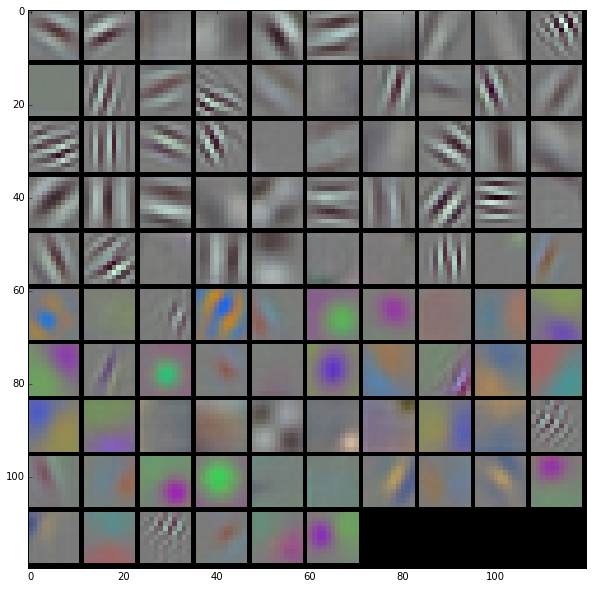

In [14]:
# the parameters are a list of [weights, biases]
filters2 = net2.params['conv1'][0].data
#print filters2.shape
vis_square(net2.params['conv1'][0].data.transpose(0,2,3,1))

In caffe, you get the model parameters via "params" et features data via "blobs" 

(203, 203)


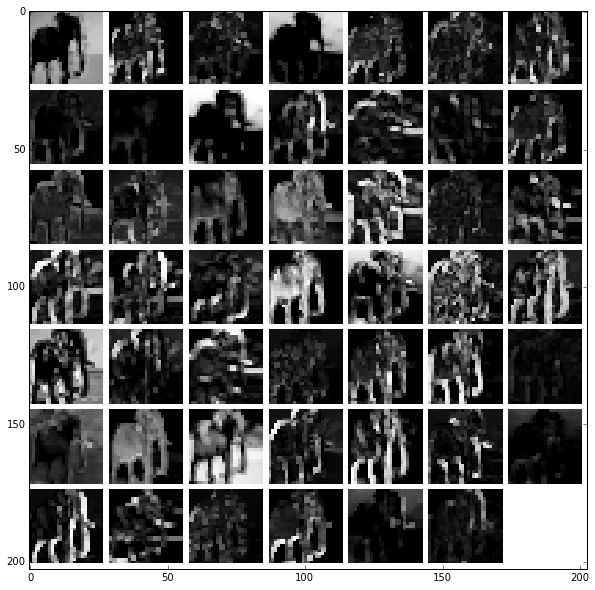

In [16]:
feat = net2.blobs['norm1'].data[0, 48:96]
vis_square(feat,2,1)

The second layer filters, conv2

There are 256 filters, each of which has dimension 5 x 5 x 48. We show only the first 48 filters, with each channel shown separately, so that each filter is a row.


(288, 288)


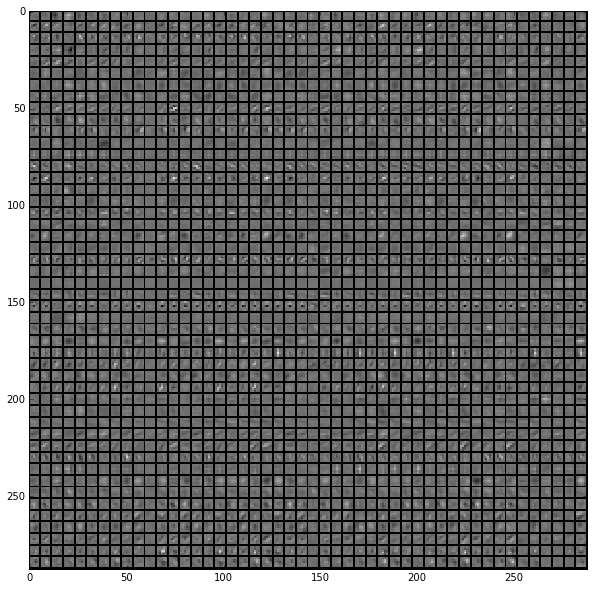

In [17]:
filters = net2.params['conv2'][0].data
vis_square(filters[:48].reshape(48**2, 5, 5))

(90, 90)


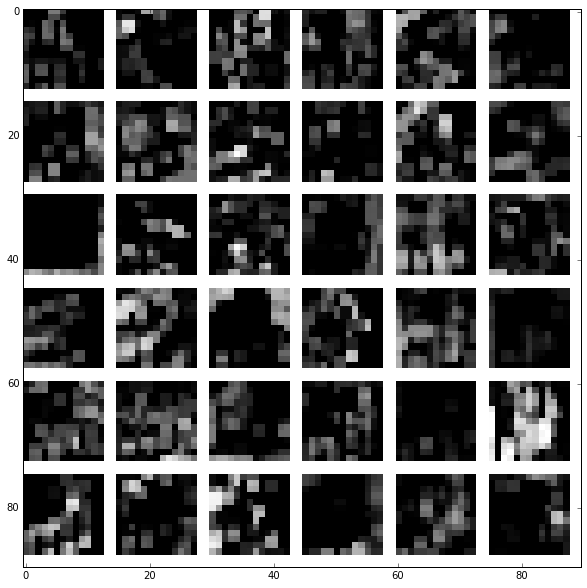

In [18]:
feat = net2.blobs['norm2'].data[0, :36]
vis_square(feat, 2, 1)

(112, 112)


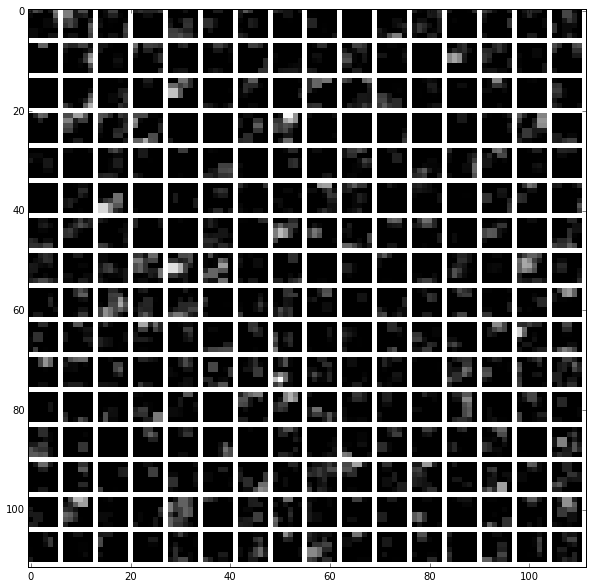

In [29]:
feat = net2.blobs['pool5'].data[0]
vis_square(feat, 1, 1)

That's it for convolutional layers... What about the "fully connected ones"?




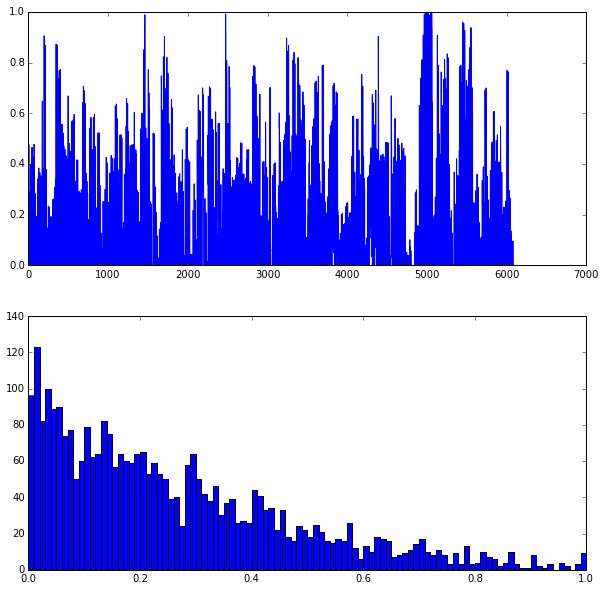

In [19]:
fc_neurons = net2.blobs['fc6']
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

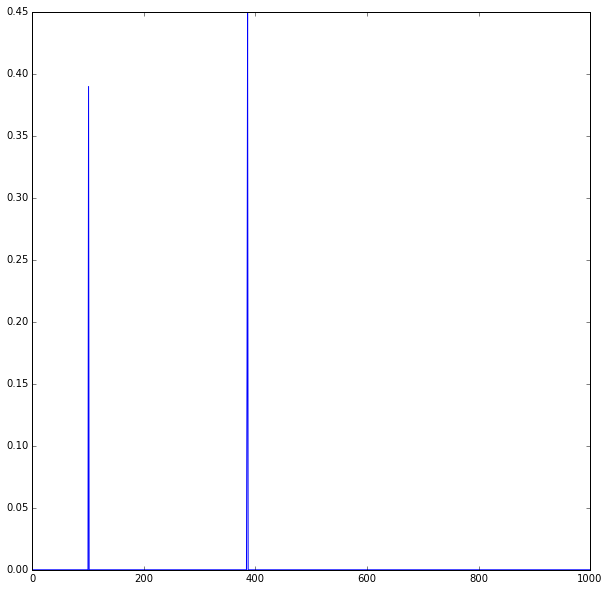

In [20]:
feat = net2.blobs['prob'].data[0]
plt.plot(feat.flat)

Couldn't import dot_parser, loading of dot files will not be possible.


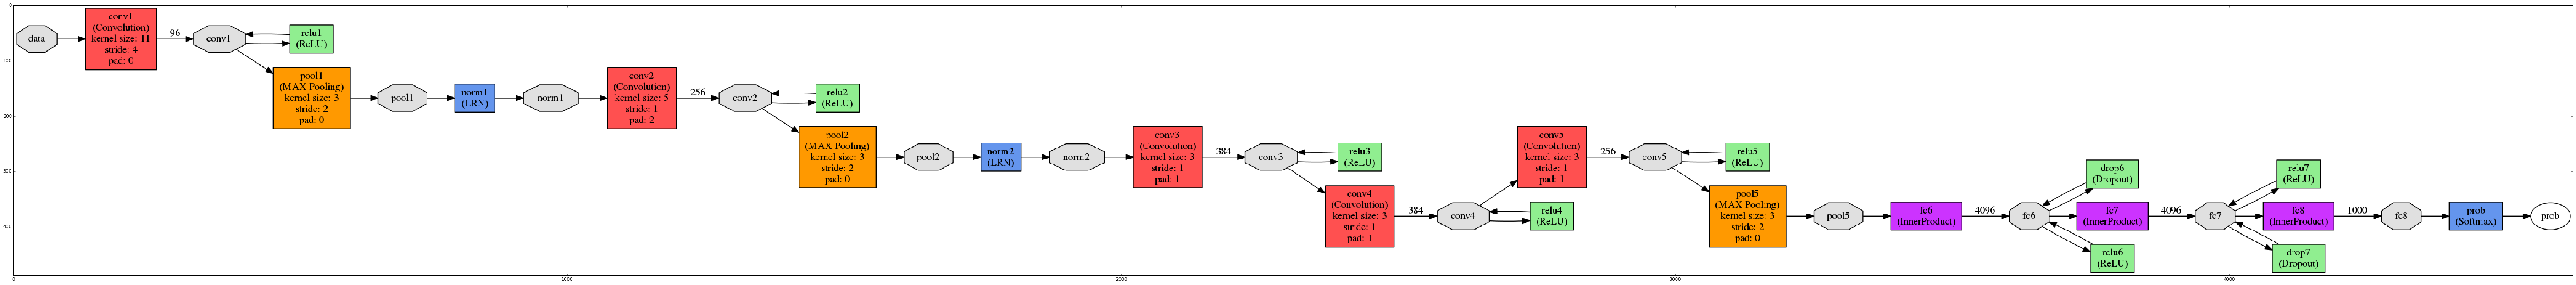

In [21]:
import caffe.draw
from caffe.proto import caffe_pb2
from google.protobuf import text_format

net20 = caffe_pb2.NetParameter()
caffenet_file = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
text_format.Merge(open(caffenet_file).read(), net20)
out_image_file = "/home/valeodar/tmp.png"
caffe.draw.draw_net_to_file(net20,out_image_file)

im1 = np.array(Image.open(out_image_file))

plt.rcParams['figure.figsize'] = (100, 100)
plt.imshow(im1)

In [33]:
plt.rcParams['figure.figsize'] = (10, 10) #Back To Small figures

# Casting a Classifier into a Fully Convolutional Network

### Above Classifier was working for only 1 patch, because last part (fully connected) was not defined as a convolution operator. It is import to understand that only the fully connected part is mainly responsible for not being able to run "dense predictions". Here we will see how to cast the fc-layers into convolutional layers

In [22]:
last_conv = net2.blobs['pool5'].data[0]
print 'last convolutional layer data shape : ',last_conv.shape,'=>',last_conv.size

params = ['fc6', 'fc7', 'fc8']
# fc_params = {name: (weights, biases)}
fc_params = {pr: (net2.params[pr][0].data, net2.params[pr][1].data) for pr in params}

for fc in params:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)


last convolutional layer data shape :  (256, 6, 6) => 9216
fc6 weights are (4096, 9216) dimensional and biases are (4096,) dimensional
fc7 weights are (4096, 4096) dimensional and biases are (4096,) dimensional
fc8 weights are (1000, 4096) dimensional and biases are (1000,) dimensional


fc params are always = output x input.size. The weight dimensions are the output and input sizes while the bias dimension is the output size.

In [23]:
# Load the fully convolutional network to transplant the parameters.
net_full_conv = caffe.Net(caffe_root+'examples/net_surgery/bvlc_caffenet_full_conv.prototxt', 
                          caffe_root+'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                          caffe.TEST)
params_full_conv = ['fc6-conv', 'fc7-conv', 'fc8-conv']
# conv_params = {name: (weights, biases)}
conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}

for conv in params_full_conv:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)


fc6-conv weights are (4096, 256, 6, 6) dimensional and biases are (4096,) dimensional
fc7-conv weights are (4096, 4096, 1, 1) dimensional and biases are (4096,) dimensional
fc8-conv weights are (1000, 4096, 1, 1) dimensional and biases are (1000,) dimensional


We can see here that fc6-conv is simply taking the last last convolutional layer size & multiplying by number of output! It is import to notice that from 256x6x6 we turn to 4096 output, so for each original patch of 227x227, it outputs at fc6 stage 4096 channels of 1x1 pixel. At fc7 stage filters are 4096x1x1 dimensional (meaning you take a carrot accross 4096 channels of 1x1 pixels! 

In [24]:
for pr, pr_conv in zip(params, params_full_conv):
    conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
    conv_params[pr_conv][1][...] = fc_params[pr][1]

Above allows to copie the original caffe model weights of fc6, fc7, fc8 & re-cast them into new filter sizes

In [25]:
net_full_conv.save(caffe_root_ex+'net_surgery/bvlc_caffenet_full_conv.caffemodel')

We saved the net

(505, 622, 3)
10 loops, best of 3: 112 ms per loop
[[101 101 101 297 297 256 366 366 366 366 366 366 295 295]
 [135 101 385 366 366 366 366 366 366 366 366 366 369 990]
 [135 101 385 366 366 366 366 366 367 369 369 369 369 985]
 [366 101 366 366 366 366 366 369 160 369 369 369 369 985]
 [366 366 366 366 366 366 295 369 256 256 256 256 267 985]
 [131 366 366 295 295 295 295 256 256 256 256 256 224 815]
 [131 357 223 223 295 295 256 256 256 226 226 226 533 998]
 [295 223 223 295 295 295 295 295 256 226 226 226 533 533]
 [295 223 312 309 295 295 295 295 295 199 199 199 533 533]
 [295 295 295 309 295 295 295 295 295 295 295 533 533 955]]


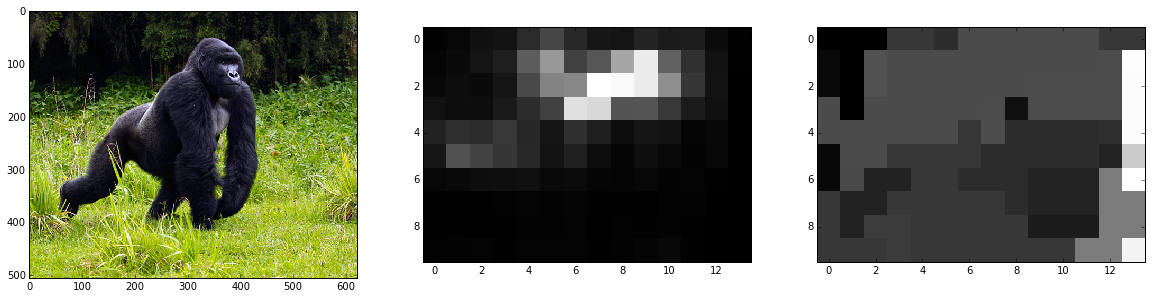

In [49]:
#configure preprocessing
tmp_image = '/home/valeodar/Images/gorilla.jpeg'
#tmp_image = '/home/valeodar/databases/INRIAPerson/Train/pos/crop001007.png' #"/home/valeodar/Images/pedestrians2.jpeg"


caffe.set_mode_gpu()
im = caffe.io.load_image(tmp_image)
print im.shape
net_full_conv.blobs['data'].reshape(1,im.shape[2],im.shape[0],im.shape[1])
transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
#transformer.set_mean('data', np.load(caffe_root+'../python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_mean('data', np.array([100,109,113]) )
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

# make classification map by forward and print prediction indices at each location
d1 = transformer.preprocess('data',im)
dd = np.asarray([transformer.preprocess('data', im)])

%timeit net_full_conv.forward_all(data=dd)

out = net_full_conv.forward(data=np.asarray([transformer.preprocess('data', im)]))
print out['prob'][0].argmax(axis=0)#accross the 1000 channels categories

#show labels instead of class numbers
classes = out['prob'][0].argmax(axis=0)


#print labels[classes]


# show net input and confidence map (probability of the top prediction at each location)
plt.rcParams['figure.figsize'] = (20, 20)
plt.subplot(1, 3, 1)
plt.imshow(transformer.deprocess('data', net_full_conv.blobs['data'].data[0]))
plt.subplot(1, 3, 2)
plt.imshow(out['prob'][0,367])
plt.subplot(1, 3, 3)
plt.imshow(classes)


In [26]:
#print top K results
hist = np.histogram(classes, bins=np.arange(0,1000))[0]
K = 10
top_results = hist.argsort()[-10:][::-1]
print labels[top_results]

NameError: name 'classes' is not defined

In [51]:
c = classes.shape.count
numwindows = out['prob'][0].shape[1]*out['prob'][0].shape[2]
naive_time_per_window_ms = 35.
fullyconv_time_per_window_ms = 53./numwindows
speed_gain = naive_time_per_window_ms / fullyconv_time_per_window_ms
print 'gain of speed is : ', speed_gain, 'tested on ', numwindows, '# windows'

gain of speed is :  92.4528301887 tested on  140 # windows


# Profiling

Here we will use the function "start=layername" & %timeit to profile time

In [52]:
#print("nparams {}".format(net_full_conv.params.keys()))
#Here we can see how to list of the different blob names :
[(k, v.data.shape) for k, v in net_full_conv.blobs.items()]

#profiling = dict()
keys = net_full_conv.params.keys()

for l in range(len(keys)-1):
    layer = keys[l]
    next_layer = keys[l+1]
    print layer, next_layer
    %timeit net_full_conv.forward(start=layer,end=next_layer) 
   

conv1 conv2
10 loops, best of 3: 21.8 ms per loop
conv2 conv3
100 loops, best of 3: 19.1 ms per loop
conv3 conv4
100 loops, best of 3: 12.9 ms per loop
conv4 conv5
100 loops, best of 3: 10.4 ms per loop
conv5 fc6-conv
10 loops, best of 3: 43.7 ms per loop
fc6-conv fc7-conv
10 loops, best of 3: 56.6 ms per loop
fc7-conv fc8-conv
10 loops, best of 3: 22 ms per loop


In [53]:
[(k, v.data.shape) for k, v in net_full_conv.blobs.items()]

[('data', (1, 3, 505, 622)),
 ('conv1', (1, 96, 124, 153)),
 ('pool1', (1, 96, 62, 76)),
 ('norm1', (1, 96, 62, 76)),
 ('conv2', (1, 256, 62, 76)),
 ('pool2', (1, 256, 31, 38)),
 ('norm2', (1, 256, 31, 38)),
 ('conv3', (1, 384, 31, 38)),
 ('conv4', (1, 384, 31, 38)),
 ('conv5', (1, 256, 31, 38)),
 ('pool5', (1, 256, 15, 19)),
 ('fc6-conv', (1, 4096, 10, 14)),
 ('fc7-conv', (1, 4096, 10, 14)),
 ('fc8-conv', (1, 1000, 10, 14)),
 ('prob', (1, 1000, 10, 14))]

In [54]:
[(k, v[0].data.shape) for k, v in net_full_conv.params.items()]

[('conv1', (96, 3, 11, 11)),
 ('conv2', (256, 48, 5, 5)),
 ('conv3', (384, 256, 3, 3)),
 ('conv4', (384, 192, 3, 3)),
 ('conv5', (256, 192, 3, 3)),
 ('fc6-conv', (4096, 256, 6, 6)),
 ('fc7-conv', (4096, 4096, 1, 1)),
 ('fc8-conv', (1000, 4096, 1, 1))]

In [56]:
#why does it take so long?
fc_neurons = net_full_conv.params['fc6-conv'][0].data
print fc_neurons.shape
neuron = fc_neurons[:,:,:,:]
#print np.mean(neuron)
#print np.std(neuron)

seri = neuron.reshape( (1,neuron.size))
print seri.shape

#histo = np.histogram(seri)[0]
#print histo
#plt.plot(histo)
print sum( sum( sum( sum( neuron > 0.9 ))))


(4096, 256, 6, 6)
(1, 37748736)
0
